<a href="https://colab.research.google.com/github/hman930/hman930/blob/main/Business_OCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 카메라 사진과 신분증 사진 비교

In [ ]:
!git clone https://github.com/serengil/deepface.git

fatal: destination path 'deepface' already exists and is not an empty directory.


In [ ]:
#필요한 라이브러리
!pip install ipywidgets matplotlib
from ipywidgets import FileUpload, Button,Output # html위젯을 사용
from IPython.display import display
import matplotlib.pyplot as plt
from PIL import Image as PILImage
import io

!pip install deepface
from deepface import DeepFace

In [ ]:
# 글로벌 변수로 이미지 객체를 초기화합니다.
global pil_image_1, pil_image_2
pil_image_1, pil_image_2 = None, None

# 업로드 버튼을 생성합니다.
upload_button_1 = FileUpload(accept='image/*', multiple=False)
upload_button_2 = FileUpload(accept='image/*', multiple=False)
process_button = Button(description="Show Images")
output_area = Output()

# 이미지 로드 및 표시 함수
def load_and_display_images():
    global pil_image_1, pil_image_2
    if upload_button_1.value and upload_button_2.value:
        # 업로드된 이미지 파일에서 바이트 데이터를 가져옵니다.
        image_data_1 = next(iter(upload_button_1.value.values()))['content']
        image_data_2 = next(iter(upload_button_2.value.values()))['content']

        # 바이트 데이터를 PIL 이미지 객체로 변환합니다.
        pil_image_1 = PILImage.open(io.BytesIO(image_data_1))
        pil_image_2 = PILImage.open(io.BytesIO(image_data_2))

        # 이미지 표시
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        axs[0].imshow(pil_image_1)
        axs[0].axis('off')  # 좌표축 끄기
        axs[0].set_title('[ID Image]')

        axs[1].imshow(pil_image_2)
        axs[1].axis('off')
        axs[1].set_title('[Self Image]')

        plt.show()

# 버튼 클릭 이벤트 핸들러
def on_button_clicked(b):
    with output_area:
        output_area.clear_output()
        load_and_display_images()

# 이벤트 핸들러 연결
process_button.on_click(on_button_clicked)

# 위젯 표시
display(upload_button_1, upload_button_2, process_button, output_area)


FileUpload(value={}, accept='image/*', description='Upload')

FileUpload(value={}, accept='image/*', description='Upload')

Button(description='Show Images', style=ButtonStyle())

Output()

특정 얼굴 이미지 인식

In [ ]:
!pip install dlib
!pip install opencv-contrib-python
!pip install dlib opencv-python
import dlib, cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patheffects as path_effects
%pwd

#/content/drive

'/content'

In [ ]:
# dlib에 CUDA를 사용하지 않도록 설정
dlib.DLIB_USE_CUDA = False

# 모델 로드 시도
detector = dlib.get_frontal_face_detector()
sp = dlib.shape_predictor('/content/drive/MyDrive/Colab Notebooks/shape_predictor_68_face_landmarks.dat')
facerec = dlib.face_recognition_model_v1('/content/drive/MyDrive/Colab Notebooks/dlib_face_recognition_resnet_model_v1.dat')
predictor=dlib.shape_predictor('/content/drive/MyDrive/Colab Notebooks/shape_predictor_68_face_landmarks.dat')

# CUDA를 사용할 수 있는지 확인합니다.
if dlib.cuda.get_num_devices() > 0:
    print("CUDA is available. You might want to enable it for faster processing.")
else:
    print("CUDA is not available. Using CPU.")

CUDA is available. You might want to enable it for faster processing.


사진 적용하기

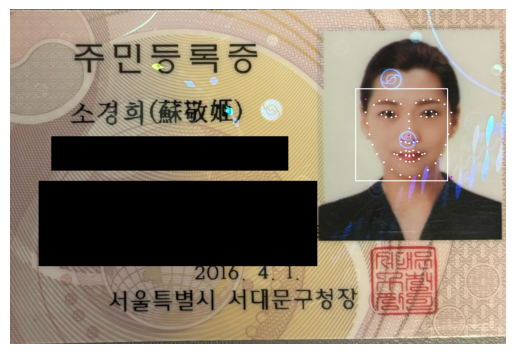

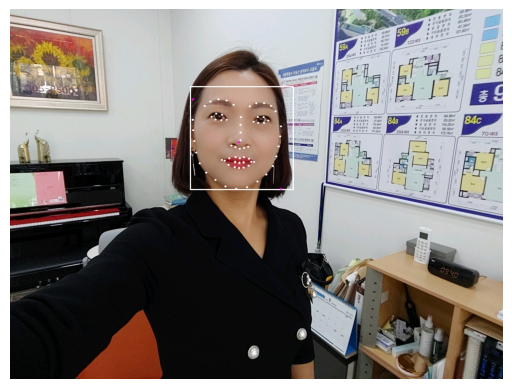

In [ ]:
#pil_image_1 -> 신분증
#pil_image_2 -> 카메라 사진

def process_image(pil_image):
    # PIL 이미지를 OpenCV 이미지(BGR)로 변환
    cv_image = cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)

    # 얼굴 감지
    faces = detector(cv_image, 1)
    if len(faces) > 0:
        face = faces[0]
        # 얼굴 주위에 사각형 그리기
        cv_image = cv2.rectangle(cv_image, (face.left(), face.top()), (face.right(), face.bottom()), (255, 255, 255), 2)

        # 랜드마크 검출
        dlib_shape = predictor(cv_image, face)
        shape_2d = np.array([[p.x, p.y] for p in dlib_shape.parts()])

        # 랜드마크에 원 그리기
        for s in shape_2d:
           cv2.circle(cv_image, center=tuple(s), radius=1, color=(255, 255, 255), thickness=2, lineType=cv2.LINE_AA)

        # 얼굴의 좌우 상하점과 중심점 계산 및 표시
        top_left = np.min(shape_2d, axis=0)
        bottom_right = np.max(shape_2d, axis=0)
        center_x, center_y = np.mean(shape_2d, axis=0).astype(int)

        cv2.circle(cv_image, center=(center_x, center_y), radius=1, color=(255, 0, 255), thickness=2, lineType=cv2.LINE_AA)
        cv2.circle(cv_image, center=tuple(top_left), radius=1, color=(255, 0, 255), thickness=2, lineType=cv2.LINE_AA)
        cv2.circle(cv_image, center=tuple(bottom_right), radius=1, color=(255, 0, 255), thickness=2, lineType=cv2.LINE_AA)

        # 이미지를 RGB로 변환하여 표시
        plt.imshow(cv2.cvtColor(cv_image, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.show()
    else:
        print("얼굴을 찾을 수 없습니다.")

#process_image 함수 사용
process_image(pil_image_1)
process_image(pil_image_2)


두 사진의 유사도 측정

In [ ]:
def process_image(pil_image):
    # PIL 이미지를 OpenCV 이미지(BGR)로 변환
    cv_image = cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)

    # 얼굴 감지
    dets = detector(cv_image, 1)
    if len(dets) == 0:
        return None  # 얼굴이 감지되지 않은 경우

    d = dets[0]  # 첫 번째 검출된 얼굴 사용
    shape = predictor(cv_image, d)
    face_descriptor = facerec.compute_face_descriptor(cv_image, shape)
    return np.array(face_descriptor)

desc1 = process_image(pil_image_1)
desc2 = process_image(pil_image_2)

# 두 얼굴 인코딩 사이의 유클리디안 거리 계산
if desc1 is not None and desc2 is not None:
    dist = np.linalg.norm(desc1 - desc2)
    print(f"두 얼굴 간의 유클리디안 거리: {dist}")

    if dist < 0.4:  # 일치 임계값
        print("인물 일치.")
    else:
        print("인물 불일치")
else:
    print("하나 또는 두 이미지에서 얼굴을 감지할 수 없습니다.")

두 얼굴 간의 유클리디안 거리: 0.3876694488816734
인물 일치.


#2. 신분증 이름과 사업자 이름 비교

In [ ]:
!pip install easyocr
!pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113

ERROR: Could not find a version that satisfies the requirement torch==1.10.2+cu113 (from versions: 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0, 2.0.1, 2.1.0, 2.1.1, 2.1.2, 2.2.0, 2.2.1, 2.2.2, 2.3.0, 2.3.1, 2.4.0)
ERROR: No matching distribution found for torch==1.10.2+cu113


In [ ]:
import easyocr
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import ImageFont, ImageDraw, Image

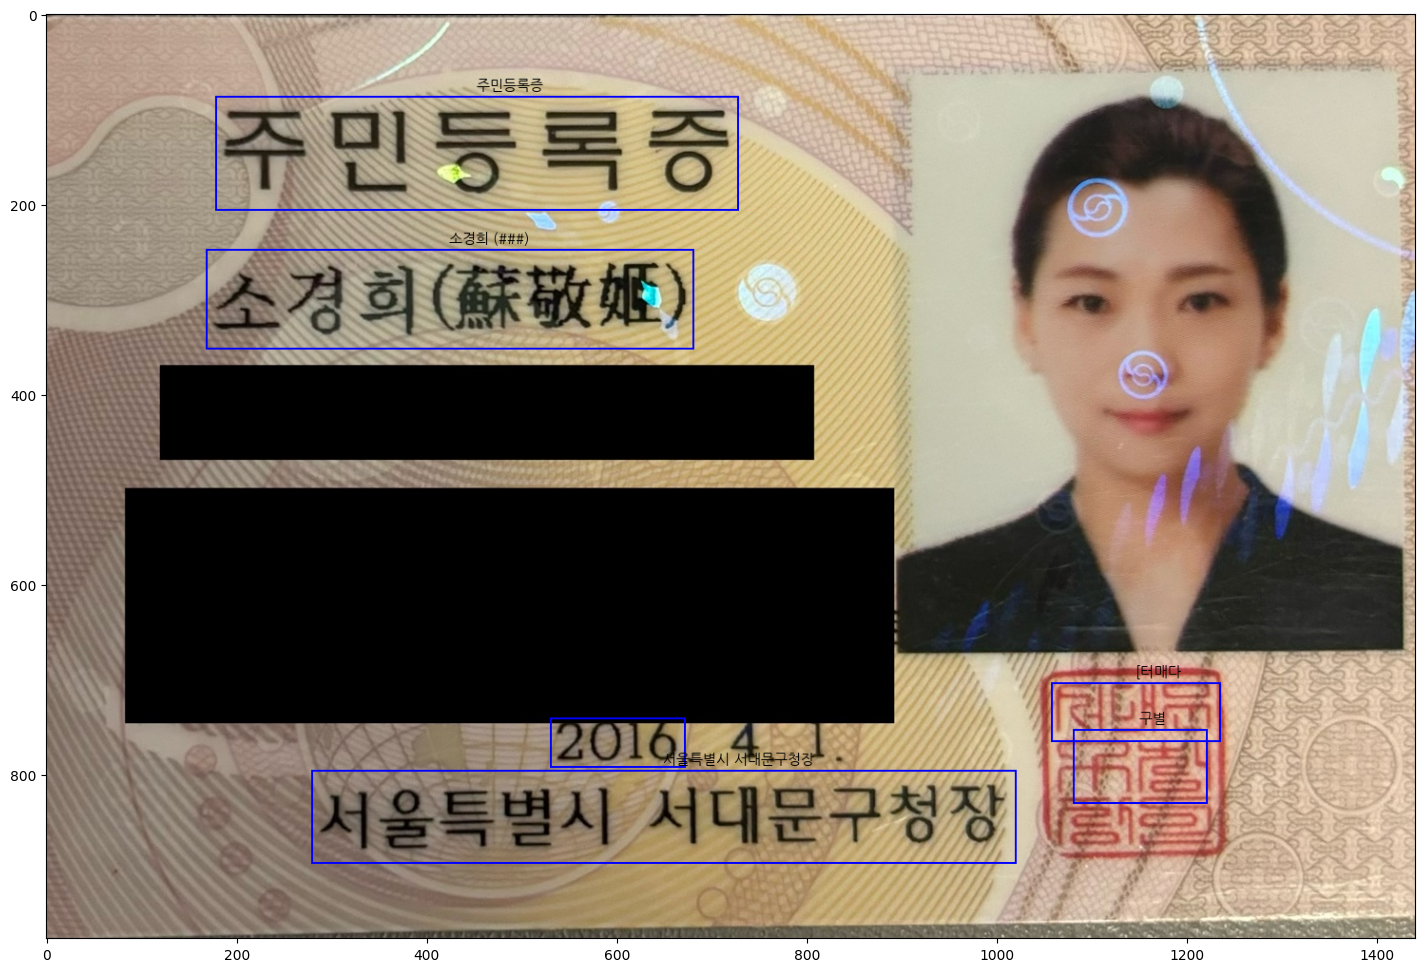

In [ ]:
# dist 값이 0.4 이상일 경우 실행 중지
if dist >= 0.4:
    print("본인 불일치")
else:
    # 이미지 읽기
    image= np.array(pil_image_1)

    # 이미지를 그레이스케일로 변환
    src = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # EasyOCR 리더 초기화
    reader = easyocr.Reader(['ko', 'en'])
    # 텍스트 인식
    result = reader.readtext(src)

    # PIL 이미지 객체로 변환
    image = Image.fromarray(image)
    # 폰트 설정
    font = ImageFont.truetype('/content/drive/MyDrive/Colab Notebooks/NanumGothic.ttf', 15)
    # 드로잉 객체 생성
    draw = ImageDraw.Draw(image)

    # 인식된 글자를 저장할 리스트
    text_list = []

    # 인식 결과 반복 처리
    for i in result:
        # 인식된 텍스트 박스 좌표 계산
        x = i[0][0][0]
        y = i[0][0][1]
        w = i[0][1][0] - i[0][0][0]
        h = i[0][2][1] - i[0][1][1]

        # 사각형 그리기
        draw.rectangle(((x, y), (x+w, y+h)), outline="blue", width=2)
        # 텍스트 그리기
        draw.text((int((x+x+w)/2), y-20), str(i[1]), font=font, fill="black")

        # 인식된 글자 리스트에 추가
        text_list.append(i[1])

    # 시각화
    plt.figure(figsize=(20, 12))
    plt.imshow(image)
    plt.show()

In [ ]:
simple_results = reader.readtext(src, detail = 0)
simple_results

['주민등록증', '소경희 (###)', '[터매다', '2016', '구별', '서울특별시 서대문구청장']

In [ ]:
# [1] 위치의 값을 이름으로 사용
name_with_extra = simple_results[1]

# '(' 이전의 내용만 추출
name = name_with_extra.split(' (')[0]  # 공백과 '('를 기준으로 분할

print("추출된 이름:", name)


추출된 이름: 소경희


FileUpload(value={}, accept='image/*', description='Upload')

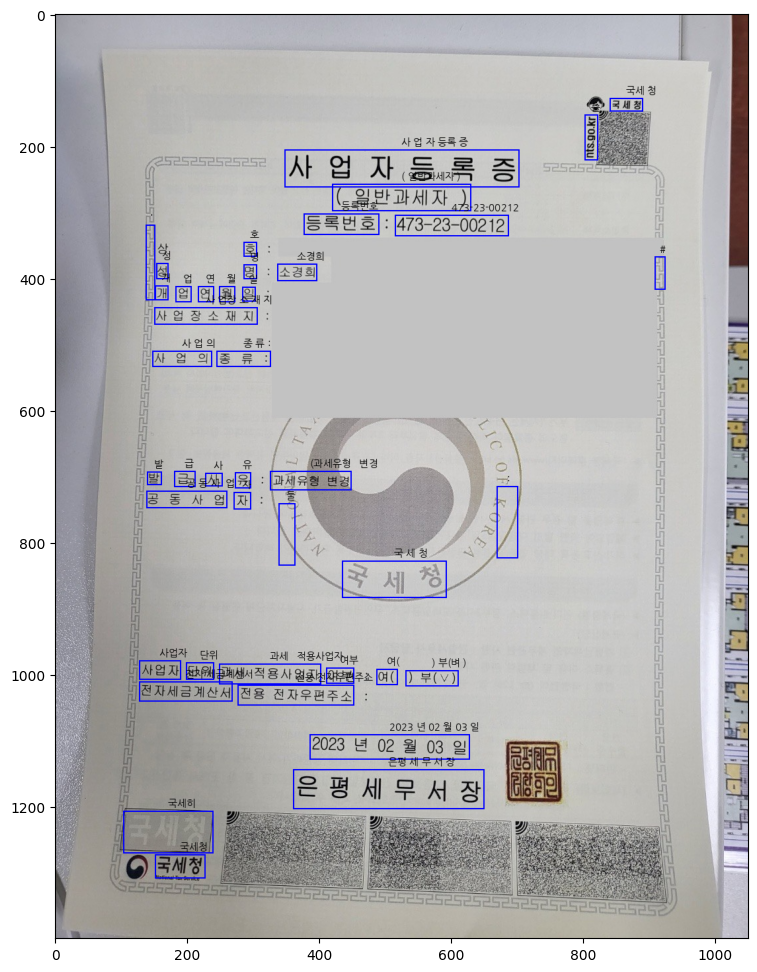

In [ ]:
#사업자 등록증 인식 추출

src1 = None

# 파일 업로드 위젯 생성
upload_button = FileUpload(accept='image/*', multiple=False)

# 업로드된 파일의 이미지 출력 및 OCR 처리 함수
def on_upload_change(change):

    global src1, result
    # 업로드된 파일이 있으면
    if change['new']:
        # 업로드된 첫 번째 파일 가져오기
        file_info = list(change['new'].values())[0]
        # 이미지를 배열로 변환
        image_np = np.frombuffer(file_info['content'], np.uint8)
        # 이미지 디코딩 (OpenCV 형식으로 변환)
        image1 = cv2.imdecode(image_np, cv2.IMREAD_COLOR)

        # 이미지를 그레이스케일로 변환
        src1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)

        # OCR 리더 초기화 및 텍스트 인식
        reader = easyocr.Reader(['ko'])
        result = reader.readtext(src1)

        # PIL 이미지로 변환
        image1_pil = PILImage.fromarray(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
        font = ImageFont.truetype('/content/drive/MyDrive/Colab Notebooks/NanumGothic.ttf', 15)
        draw = ImageDraw.Draw(image1_pil)

        # 인식된 텍스트 박스 그리기 및 텍스트 표시
        for i in result:
            x = i[0][0][0]
            y = i[0][0][1]
            w = i[0][1][0] - i[0][0][0]
            h = i[0][2][1] - i[0][1][1]

            draw.rectangle(((x, y), (x+w, y+h)), outline="blue", width=2)
            draw.text((int((x+x+w)/2), y-20), str(i[1]), font=font, fill="black")

        # 결과 이미지 시각화
        plt.figure(figsize=(20,12))
        plt.imshow(image1_pil)
        plt.show()

# 파일 업로드 위젯에 변경 사항이 있을 때 호출될 함수 연결
upload_button.observe(on_upload_change, names='value')

# 파일 업로드 버튼 표시
display(upload_button)


In [ ]:
simple_results1 = reader.readtext(src1, detail = 0)
simple_results1

['국세 청',
 '출',
 '사 업 자 등록 증',
 '( 일반과세자 )',
 '등록번호',
 '473-23-00212',
 '호',
 "'",
 '성',
 '명',
 '소경희',
 '#',
 '개',
 '업',
 '연',
 '월',
 '일',
 '사 업장 소 재 지',
 '사 업 의',
 '종 류 :',
 '발',
 '급',
 '사',
 '유',
 '(과세유형   변경',
 '공 동 사  업',
 '자',
 '국 세 청',
 '사업자',
 '단위',
 '과세   적용사업자',
 '여부',
 '여(',
 ') 부(V )',
 '전자 세금계산서',
 '전용 전자우편주소',
 '2023 년 02 월 03 일',
 '은평 세 무 서 장',
 '국세히',
 '국세청',
 ':',
 '둘']

In [ ]:
other_items = simple_results1[:]

authentication_status = "일치하지 않습니다."
for item in other_items:
    if name in item:
        authentication_status = "본인인증완료"
        break  # 이름이 확인되면 루프 종료

print(authentication_status)

본인인증완료


In [ ]:
import re

# 사업자 번호 추출을 위한 정규 표현식
pattern = r'\b\d{3}-\d{2}-\d{5}\b'

# 리스트 내 각 문자열을 검사하여 사업자 번호 추출
for item in simple_results1:
    match = re.search(pattern, item)
    if match:
        # 하이픈 제거
        business_number = match.group().replace('-', '')
        print(business_number)

4732300212


#3. 사업자번호 조회

In [ ]:
import requests
import json

# API를 호출할 URL과 헤더, 파라미터 설정
# 공공포탈데이터
url = "https://api.odcloud.kr/api/nts-businessman/v1/status"
service_key = 'hXbQNkiYngQ2zAPUqjdPGoSEXXMT5JW5Xqy40R6QX1jQeEQegLEJ1g6t0vRtcVUURU4kJXoXpFHZnpy8OyRuZA%3D%3D'
headers = {
    'Content-Type': 'application/json',
    'Accept': 'application/json'
}


# 사업자번호가 없을 경우 처리
if not business_number:
    print("등록번호를 찾을 수 없습니다.")
else:
    data = {
        "b_no": [business_number]  # 사업자번호를 리스트로 제공
    }

    # API 호출
    response = requests.post(url=f"{url}?serviceKey={service_key}&returnType=JSON",
                             headers=headers, data=json.dumps(data))

    # 응답 확인
    if response.status_code == 200:
        result = response.json()

        # API 응답에서 사업자 상태 코드 가져오기
        business_status = result.get('data', [])[0].get('b_stt_cd', '')

        # 사업자 상태 코드 확인
        if business_status in ['01', '02']:
            print("사업자 확인 완료")
        else:
            print("관리자 확인 요청 바랍니다.")
    else:
        print("Error:", response.status_code, response.text)

# 사업자등록 상태조회 결과{
# b_no	string
# default: 0000000000
# xml: OrderedMap { "name": "BNo" }
# 사업자등록번호


# xml:
#    name: BNo
# b_stt	string
# default: 계속사업자
# xml: OrderedMap { "name": "BStt" }
# 납세자상태(명칭):
# 01: 계속사업자,
# 02: 휴업자,
# 03: 폐업자


# xml:
#    name: BStt
# b_stt_cd	string
# default: 01
# xml: OrderedMap { "name": "BSttCd" }
# 납세자상태(코드):
# 01: 계속사업자,
# 02: 휴업자,
# 03: 폐업자


# xml:
#    name: BSttCd
# tax_type	string
# default: 부가가치세 일반과세자
# xml: OrderedMap { "name": "TaxType" }
# 과세유형메세지(명칭):
# 01:부가가치세 일반과세자,
# 02:부가가치세 간이과세자,
# 03:부가가치세 과세특례자,
# 04:부가가치세 면세사업자,
# 05:수익사업을 영위하지 않는 비영리법인이거나 고유번호가 부여된 단체,국가기관 등,
# 06:고유번호가 부여된 단체,
# 07:부가가치세 간이과세자(세금계산서 발급사업자),
# * 등록되지 않았거나 삭제된 경우: "국세청에 등록되지 않은 사업자등록번호입니다"


# xml:
#    name: TaxType
# tax_type_cd	string
# default: 01
# xml: OrderedMap { "name": "TaxTypeCd" }
# 과세유형메세지(코드):
# 01:부가가치세 일반과세자,
# 02:부가가치세 간이과세자,
# 03:부가가치세 과세특례자,
# 04:부가가치세 면세사업자,
# 05:수익사업을 영위하지 않는 비영리법인이거나 고유번호가 부여된 단체,국가기관 등,
# 06:고유번호가 부여된 단체,
# 07:부가가치세 간이과세자(세금계산서 발급사업자)


# xml:
#    name: TaxTypeCd
# end_dt	string
# default: 20000101
# xml: OrderedMap { "name": "EndDt" }
# 폐업일 (YYYYMMDD 포맷)


# xml:
#    name: EndDt
# utcc_yn	string
# default: Y
# xml: OrderedMap { "name": "UtccYn" }
# 단위과세전환폐업여부(Y,N)


# xml:
#    name: UtccYn
# tax_type_change_dt	string
# default: 20000101
# xml: OrderedMap { "name": "TaxTypeChangeDt" }
# 최근과세유형전환일자 (YYYYMMDD 포맷)


# xml:
#    name: TaxTypeChangeDt
# invoice_apply_dt	[...]
# rbf_tax_type	string
# default: 부가가치세 일반과세자
# xml: OrderedMap { "name": "RbfTaxType" }
# 직전과세유형메세지(명칭):
# 01:부가가치세 일반과세자,
# 02:부가가치세 간이과세자,
# 07:부가가치세 간이과세자(세금계산서 발급사업자),
# 99:해당없음


# xml:
#    name: RbfTaxType
# rbf_tax_type_cd	string
# default: 01
# xml: OrderedMap { "name": "RbfTaxTypeCd" }
# 직전과세유형메세지(코드):
# 01:부가가치세 일반과세자,
# 02:부가가치세 간이과세자,
# 07:부가가치세 간이과세자(세금계산서 발급사업자),
# 99:해당없음


# xml:
#    name: RbfTaxTypeCd
# }

사업자 확인 완료
